# Praca domowa 2
## Emilia Matrejek 100916

In [1]:
import numpy as np
import pandas as pd

W pierwszym kroku definiuję funkcję, która oblicza współczynniki regresji metodą najmniejszych kwadratów (KMNK).

In [43]:
def check_and_reshape_X(X):
    if isinstance(X, pd.Series):  # Jeśli X jest Pandas Series
        X = X.to_numpy()  # Konwertujemy na NumPy array
    if X.ndim == 1:  # Jeśli X jest wektorem 1D, przekształć na 2D
        X = X.reshape(-1, 1)  # Konwertuj na macierz o kształcie (n, 1)
    return X

In [ ]:
def fit_linear_model(X, y):
    X = check_and_reshape_X(X) 
    X_with_intercept = np.c_[np.ones(X.shape[0]), X]  ##dodanie kolumny z jedynkami dla wyrazu wolnego
    
    try:
        beta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y ##zgodnie ze wzorem na betę
    except np.linalg.LinAlgError:
        lambda_identity = np.eye(X_with_intercept.shape[1]) * 1e-8
        beta = np.linalg.inv(X_with_intercept.T @ X_with_intercept + lambda_identity) @ X_with_intercept.T @ y
    return beta

Następnie definiuję funkcję, która oblicza reszty i macierz inf (dźwigni).

In [4]:
def calculate_residuals_and_influence(X, y, beta):
    X = check_and_reshape_X(X)
    X_with_intercept = np.c_[np.ones(X.shape[0]), X] ##dodaję do macierzy X kolumnę z jedynkami, aby uwzględnić wyraz wolny
    y_pred = X_with_intercept @ beta # obliczam prognozowane y za pomocą współczynnika beta uzyskanego w poprzedniej funkcji
    residuals = y - y_pred # obliczam reszty
    inf = X_with_intercept @ np.linalg.pinv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T # definiowanie macierzy inf (od influence matrix) - jest to macierz, która mapuje wektor rzeczywistych wartości y na wektor prognoz
    #zgodnie ze wzorem z wykładu
    #tutaj na przekątnej są wartości reprezentujące dźwignię
    return residuals, inf

Trzecia funkcja - obliczanie wartości miary D Cooka - różnica w wynikach procedury w wypadku hipotetycznego usunięia i nieusunięcia danej obserwacji z próby

In [5]:
def cook_distance(X, y, beta):
    residuals, inf = calculate_residuals_and_influence(X, y, beta) ## obliczamy resztę i macierz inf z poprzedniej funkcji
    mse = np.mean(residuals**2) ## tutaj w internecie znalazłam wzór który wykorzystuje właśnie elementy przekątnej macierzy wpływu, najpierw liczę średni błąd kwadratowy
    if X.ndim == 1:
        X = X.to_numpy().reshape(-1, 1)
    cook_d = (residuals**2 / (X.shape[1] * mse)) * (inf.diagonal() / (1 - inf.diagonal())**2) ## i tutaj według tego wzoru miarę D Cooka
    return cook_d

Teraz definiuję funkcję do regresji odpornej - będzie zmniejszała wagi obserwacji odstających (zidentyfikowanych na podstawie miary D Cooka

In [40]:

def robust_regression(X, y, max_iter=10): #na razie maksymalna liczba iteracji to 10
    X = check_and_reshape_X(X)
    threshold=4 / len(y) # tutaj jako threshold ustaliłam 4/len(y), też znalazłam w internecie że stosuje się 4/n
 
    
    
    beta = fit_linear_model(X, y) # Inicjalizacja współczynników za pomocą pierwszej funkcji
    
    for i in range(max_iter):
        
        cook_d = cook_distance(X, y, beta) # Obliczanie reszt i statystyki Cooka za pomocą ostatniej funkcji
        
        
        outliers = np.where(cook_d > threshold)[0] # Zidentyfikowanie punktów odstających
        
        if len(outliers) == 0:
            break  # Jeśli nie ma punktów odstających, zakończymy iterację
        
        
        weights = np.ones(len(y)) # Zastosowanie wag, zmniejszając wagę punktów odstających
        weights[outliers] = 0.1  # Zmniejszamy wagę punktów odstających, tutaj stosuję 0.1

        # Dopasowanie modelu z nowymi wagami
        X_weighted = X * np.sqrt(weights[:, np.newaxis])
        y_weighted = y * np.sqrt(weights)
        beta = fit_linear_model(X_weighted, y_weighted)
    
    return beta, outliers

Na koniec funkcja do resamplingu

In [ ]:
def bootstrap_resampling(X, y, regression_function, n_iter=1000):

    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series): ##tu tylko technicznie konwersja na numpy jeśli są w formacie Pandas DataFrame
        X = X.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()

    n = len(y)
    coefs = [] ##lista, która będzie przechowywać współczynniki regresji dla każdej próbki bootstrapowej

    ##pętla bootstrapowa
    for _ in range(n_iter):
        indices = np.random.choice(n, size=n, replace=True)  ##tworzę próbkę bootstrapową - losowanie ze zwracaniem
        X_resampled, y_resampled = X[indices], y[indices] #tworzenie próbek z X i y na podstawie wylosowanych indeksów

        # dopasowanie modelu do próbki
        beta_resampled, _ = regression_function(X_resampled, y_resampled) ##teraz normalnie stosuje się tą funkcję ale tylko na wylosowanej próbce
        coefs.append(beta_resampled)

    coefs = np.array(coefs)  ##teraz mamy macierz, gdzie każdy wiersz to współczynniki z jednej próby bootstrapowej
    coef_means = np.mean(coefs, axis=0) ##obliczamy średnie współczynniki na podstawie wyników z wszystkich prób
    coef_stds = np.std(coefs, axis=0) ##obliczamy odchylenie standardowe dla każdego współczynnika regresji

    return coef_means, coef_stds

Na przykładowych danych:

In [ ]:
file_path = ...

df = pd.read_csv(file_path)

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,usa
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,usa
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,usa
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,usa
4,ford torino,17.0,8,302.0,140.0,3449,10.5,70,usa


In [ ]:
df = df.dropna() ##konieczne jest usunięcie braków danych

In [ ]:
X = df[...]
y = df[...]

In [44]:
beta, outliers = robust_regression(X, y)

print(f"Szacowane współczynniki regresji: {beta}")
print(f"Indeksy punktów odstających (Cook's Distance > threshold): {outliers}")
    

coef_means, coef_stds = bootstrap_resampling(X, y, robust_regression)
print(f"Średnie współczynniki (Bootstrap): {coef_means}")
print(f"Odchylenia standardowe współczynników (Bootstrap): {coef_stds}")

Szacowane współczynniki regresji: [7.05063357 0.03176854]
Indeksy punktów odstających (Cook's Distance > threshold): [  1   5   6   7   8   9  10  11  13  23  25  26  27  28  37  38  62  66
  69  84  89  93  94  95 102 105 115 123 152 161 198 210 220 227 228 229
 261 295 324 326]
Średnie współczynniki (Bootstrap): [7.69747394 0.03149313]
Odchylenia standardowe współczynników (Bootstrap): [3.54308904e+00 1.46734519e-03]


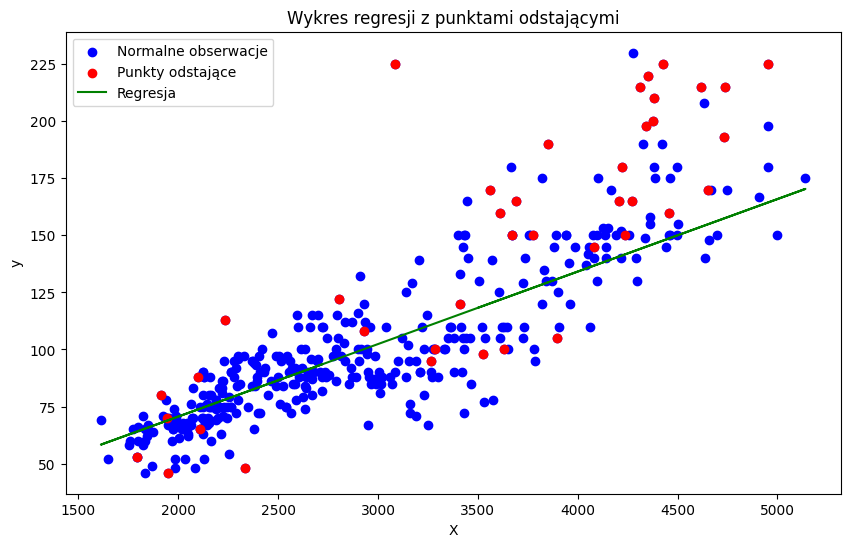

In [49]:
import matplotlib.pyplot as plt

##predykcje dla modelu regresji
X_with_intercept = np.c_[np.ones(X.shape[0]), X]  ##dodanie kolumny z jedynkami dla wyrazu wolnego
y_pred = X_with_intercept @ beta  ##prognozowane wartości y

plt.figure(figsize=(10, 6))

##rysuję wszystkie punkty (normalne i odstające)
plt.scatter(X, y, color='blue', label='Normalne obserwacje')

##teraz punkty odstające
plt.scatter(X[outliers], y[outliers], color='red', label='Punkty odstające')

##Linia regresji
plt.plot(X, y_pred, color='green', label='Regresja')

plt.title("Wykres regresji z punktami odstającymi")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()